In [120]:
import asyncio
import websockets
import json
import pandas as pd
import datetime as dt
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
nest_asyncio.apply()
from scipy import stats

import datetime
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import skewnorm

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Strategy Outline
1. Short (lower strike) puts and (higher strike) calls
2. Strategy assumes vol will stay muted and we harvest theta yield over time
3. Find risk-neutral implied probabiltiies of option expiring in the money for the puts and calls
4. Short calls where the probability of the option expiring with price > chosen strike is less than 10% -15%
5. Short puts where the probability of the option expiring with price < chosen strike is less than 10%-15%
6. Stop-loss when probability of getting exercised by the expiry is > 60% - 70%.
6. In essence, probability of stopping out per trade will be 20%-30% at initiation since could be 60% at the highest (at which point we will stop out)

In [121]:
hdata = HistData('ETH')

## Options

In [122]:

opt = Options('ETH')
curr_price = hdata.get_idx_price()
#curr_price

## Get all active Eth options

### Get actively traded option chains

In [123]:
option_chain_call= opt.get_option_chain(pd.datetime.today(),option_type='call')
option_chain_put= opt.get_option_chain(pd.datetime.today(),option_type='put')
option_chain_call['scaled_iv'] = option_chain_call['mark_iv']*np.sqrt(option_chain_call['dte']/360)
option_chain_put['scaled_iv'] = option_chain_put['mark_iv']*np.sqrt(option_chain_put['dte']/360)

746 active options.
1710542664572
Expiration Date:  2024-03-29 16:00:00
746 active options.
1710542679835
Expiration Date:  2024-03-29 16:00:00


### Get Implied Probabilities
1. First method is to use the IV's themselves as the vol to calculate the implied probabilities
2. Second method is to use the atm strike's IV to calcualte the implied probabilities (Assumes a true normal distribution)

## Method 1

In [124]:
mu = 0.8
t = (option_chain_call['expiration_date'].iloc[0]-pd.datetime.today()).days/360
curr_price = curr_price * np.exp(mu*t)
curr_price

3181.9203598854424

In [125]:
option_chain_call_adj=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put_adj=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put_adj,option_chain_call_adj])

1.9879846453622547


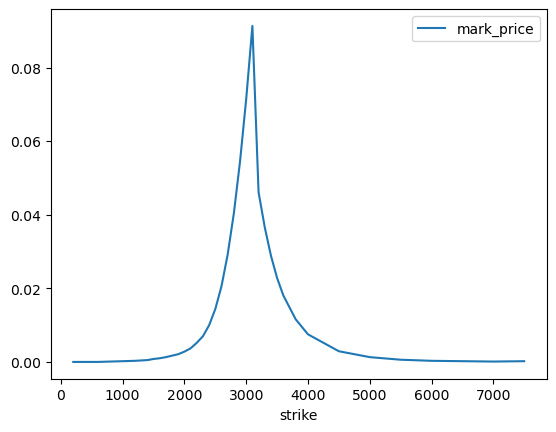

In [126]:
option_chain_full[['strike','mark_price']].set_index('strike').plot()
skewness = stats.skew(option_chain_full[['strike','mark_price']].set_index('strike'))[0]
print(skewness)

In [127]:
option_chain_call['implied_probability'] = 1-norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*option_chain_call['scaled_iv']/100)
option_chain_put['implied_probability'] = norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*option_chain_put['scaled_iv']/100)


option_chain_call=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put,option_chain_call])
option_chain_full['implied_probability'] = option_chain_full['implied_probability']*(0.5/option_chain_full['implied_probability'].max())

<Axes: title={'center': 'Option Implied Probabilities of ETH Expiration Price'}, xlabel='strike'>

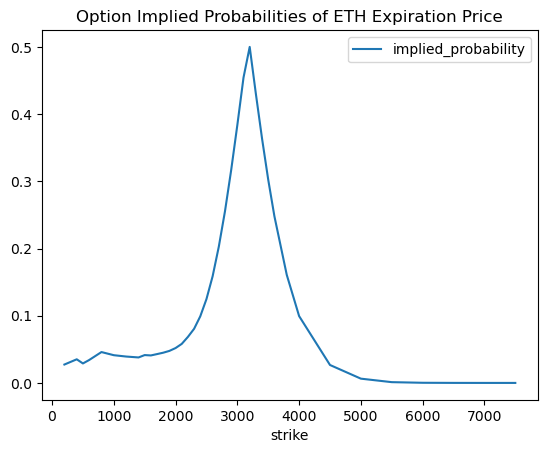

In [128]:
option_chain_full[['strike','implied_probability']].set_index('strike').plot(title='Option Implied Probabilities of ETH Expiration Price')

In [129]:
option_chain_full[['strike','implied_probability']]

,strike,implied_probability
0,200.0,0.027363
0,400.0,0.035151
0,500.0,0.028984
0,600.0,0.034036
0,800.0,0.045935
0,1000.0,0.041265
0,1200.0,0.039257
0,1400.0,0.037908
0,1500.0,0.041439
0,1600.0,0.040903


## Method 2

In [130]:
option_chain_call= opt.get_option_chain(pd.datetime.today(),option_type='call')
option_chain_put= opt.get_option_chain(pd.datetime.today(),option_type='put')
option_chain_call['scaled_iv'] = option_chain_call['mark_iv']*np.sqrt(option_chain_call['dte']/360)
option_chain_put['scaled_iv'] = option_chain_put['mark_iv']*np.sqrt(option_chain_put['dte']/360)

746 active options.
1710542694564
Expiration Date:  2024-03-29 16:00:00
746 active options.
1710542710327
Expiration Date:  2024-03-29 16:00:00


In [131]:
call_iv = option_chain_call[option_chain_call['strike']==curr_price- curr_price%100]['scaled_iv'][0]
put_iv = option_chain_put[option_chain_put['strike']==curr_price- curr_price%100]['scaled_iv'][0]

In [132]:
option_chain_call['implied_probability'] = 1-norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*call_iv/100)
option_chain_put['implied_probability'] = norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*put_iv/100)

In [133]:
option_chain_call=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put,option_chain_call])

<Axes: title={'center': 'Option Implied Probabilities of ETH Expiration Price'}, xlabel='strike'>

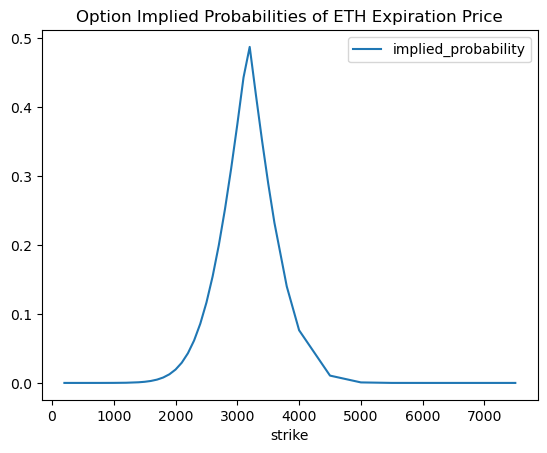

In [134]:
option_chain_full[['strike','implied_probability']].set_index('strike').plot(title='Option Implied Probabilities of ETH Expiration Price')

In [135]:
option_chain_full[['strike','implied_probability']]

,strike,implied_probability
0,200.0,9.350887e-08
0,400.0,5.803255e-07
0,500.0,1.383087e-06
0,600.0,3.200686e-06
0,800.0,1.569644e-05
0,1000.0,6.848972e-05
0,1200.0,2.661035e-04
0,1400.0,9.214728e-04
0,1500.0,1.642864e-03
0,1600.0,2.847188e-03


## Vol Skew

<Axes: xlabel='strike'>

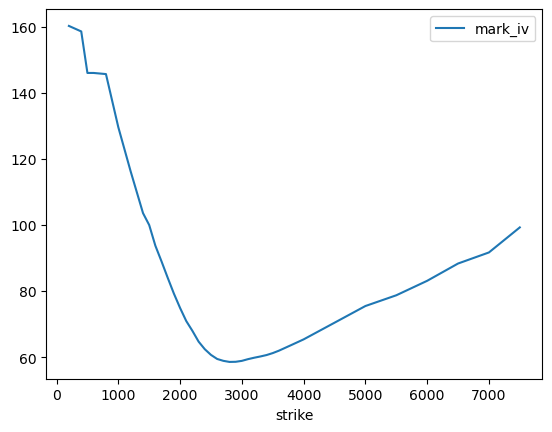

In [136]:
option_chain_full[['strike','mark_iv']].set_index('strike').plot()

## IV Adjusted Premium Calc

In [160]:
option_chain_full['adjusted_iv']=(option_chain_full['mark_iv'])**3
option_chain_full['iv_adjusted_mark_price']=option_chain_full['adjusted_iv']*option_chain_full['mark_price']

<Axes: xlabel='strike'>

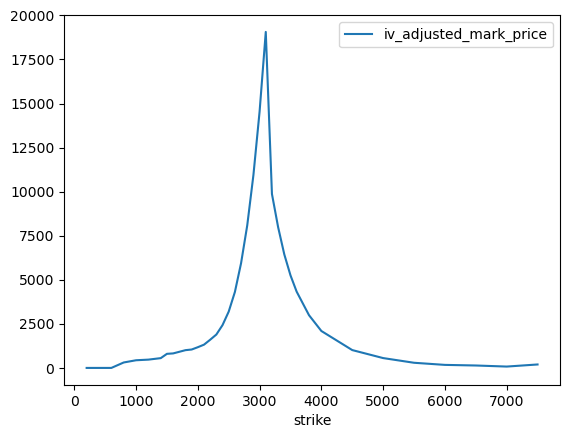

In [161]:
option_chain_full[['strike','iv_adjusted_mark_price']].set_index('strike').plot()

In [180]:
iv_gradient = pd.DataFrame(abs(option_chain_full['mark_iv'].diff()))
iv_gradient.index = option_chain_full['strike']
iv_gradient = iv_gradient[(iv_gradient.index>curr_price - 1000) & (iv_gradient.index<curr_price +1000)]

<Axes: xlabel='strike'>

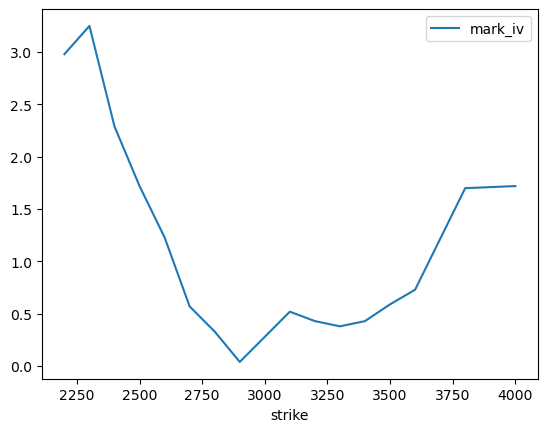

In [181]:
iv_gradient.plot()

In [140]:
start = int(pd.to_datetime('20221231').timestamp()*1000)
end = int(pd.datetime.today().timestamp()*1000)
timeframe = '1D'

# Offline

In [3]:
import os
import pandas as pd
os.getcwd()

'c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility'